In [ ]:
# Install packages

import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install kneed
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install gower

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from itertools import combinations
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from kneed import KneeLocator
import io
import pickle
import seaborn as sns
import gower
import os
from sklearn.utils import resample

# Running this project

Sections of this project are best run on a cloud or remote machine-learning environment such as Google Colab or Amazon Sagemaker due to their resource demands. I used Google Colab's free tier, and I think that's the easiest one to set up quickly

In [3]:
# Read csv

# # For reading locally
# df = pd.read_csv('data.csv')

# Uncomment to mount to Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Uncomment to read csv in Google Colab
df = pd.read_csv('/content/drive/My Drive/data.csv')

print(df.head())

Mounted at /content/drive
   model_year     km  price  is_new  fuel_id  doors  transmission_id  \
0        2018  66715  88900   False        5      4                2   
1        2015  74660  97990   False        5      4                1   
2        2014  94000  51990   False        5      4                2   
3        2013  90500  39900   False        5      4                2   
4        2014    123  47990   False        5      4                1   

   body_style_id  model_id  
0              8      7174  
1              7       282  
2              8       351  
3              2       808  
4              1      1153  


In [4]:
# Preprocess dataset (remove obvious superfluous columns and convert non-numerical data)

def preprocess_data(data):
  # Convert non-numerical columns to numerical
  # 1 = new, 0 = old
  data["is_new"] = data.apply(lambda x: 1 if x["is_new"] == True else 0, axis=1)
  return data

df_clean = preprocess_data(df)

In [ ]:
# Display current columns

column_names = df_clean.columns
column_names_list = list(column_names)
print(column_names_list)

['model_year', 'km', 'price', 'is_new', 'fuel_id', 'doors', 'transmission_id', 'body_style_id', 'model_id']


# Scaling

## Choosing a scaler

- **StandardScaler**: Assumes data is normally distributed within each feature. It scales the data to have mean = 0 and variance = 1. Suitable for features that are approximately normally distributed.

- **MinMaxScaler**: Scales the data within a given range, typically [0, 1]. It's useful when you want to preserve zero entries in sparse data.

- **RobustScaler**: Useful when your data contains outliers. It uses the median and the interquartile range for scaling, making it less sensitive to outliers.

I have chosen to use `RobustScaler` due to the quantity and range of the outliers in `km` and `price`.

In [5]:
# Scale data and convert categorical data

def scale_encode_data(raw_df, preprocessor=None):
# Features to scale and to encode
  features_to_scale = ["km", "price"]
  features_to_encode = ["is_new", "fuel_id", "doors", "transmission_id", "body_style_id", "model_id"]

  if preprocessor is None:
      # Setting up the ColumnTransformer
      preprocessor = ColumnTransformer(
          transformers=[
              ('num', RobustScaler(), features_to_scale),
              ('cat', OneHotEncoder(), features_to_encode)
          ])
      transformed_data = preprocessor.fit_transform(raw_df)
  else:
      transformed_data = preprocessor.transform(raw_df)

  # Apply the transformations
  return features_to_scale, features_to_encode, transformed_data, preprocessor

features_to_scale, features_to_encode, car_data_preprocessed, fitted_preprocessor = scale_encode_data(df_clean)

# Convert the sparse matrix to a dense numpy array
car_data_dense = car_data_preprocessed.toarray()

# KMeans Evaluation with Feature Set

## Metrics to Identify Ideal Cluster Number

- **Silhouette Score** (resource intensive): Highest point corresponds to ideal cluster number
- **Davies-Bouldin Index**: Lowest point corresponds to ideal cluster number
- **Principal Component Analysis (PCA)**: Groupings with least overlap in the PCA plot are ideal cluster groupings
- **Sum Squared Error (SSE) and Knee Locator**: The point where the slope of the plot dramatically stops decreasing is the ideal cluster groupings. This is called the "knee". Knee Locator finds this point for us automatically.


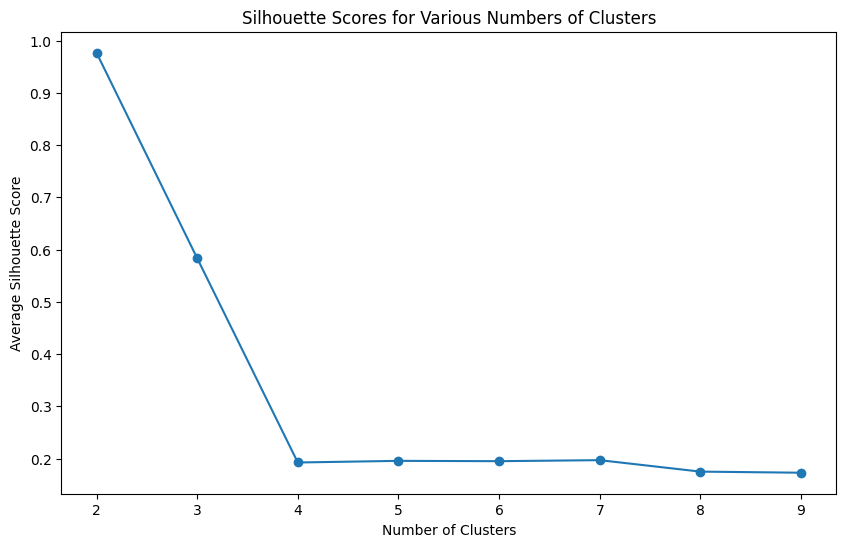

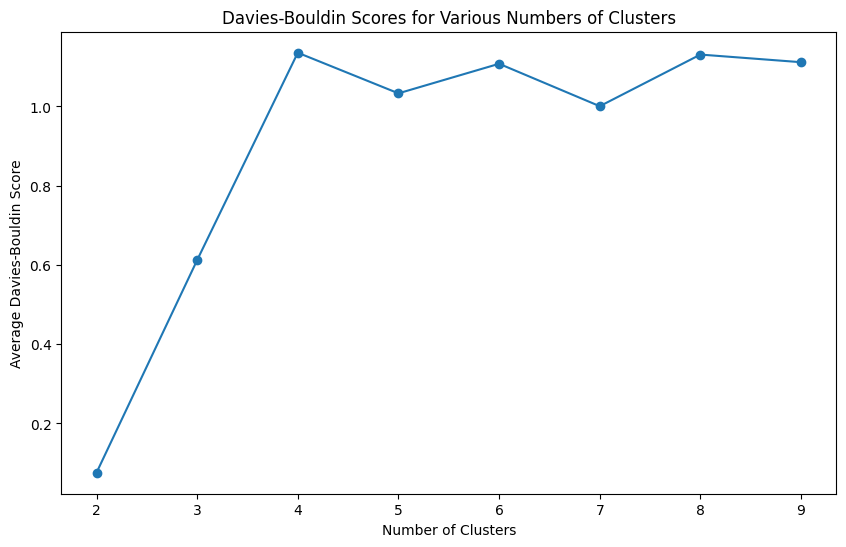

In [ ]:
# Evaluating features using silhouette score and Davies-Bouldin Index

# Range of potential clusters
range_n_clusters = range(2, 10)  # Adjust as necessary

# Store average silhouette scores for different number of clusters
silhouette_avg_scores = []
davies_bouldin_scores = []

for n_clusters in range_n_clusters:
    # Initialize KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    cluster_labels = kmeans.fit_predict(car_data_preprocessed)

    # Silhouette Score
    silhouette_avg = silhouette_score(car_data_preprocessed, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

    # Davies-Bouldin Score
    davies_bouldin_avg = davies_bouldin_score(car_data_dense, cluster_labels)
    davies_bouldin_scores.append(davies_bouldin_avg)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

# Plot Davies-Bouldin Scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Scores for Various Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Davies-Bouldin Score')
plt.show()

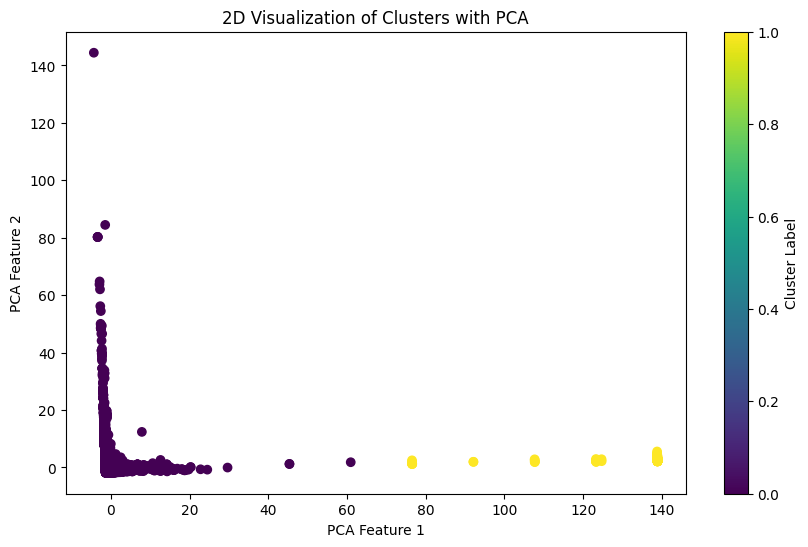

In [6]:
# Evaluate features using PCA (using optimal clusters from previous graphs)

# Choose the number of clusters based on the previous analysis
optimal_n_clusters = 2  # 2 had the optimal average Silhouette/Davies-Bouldin scores

# Initialize and fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, n_init='auto', random_state=0)
cluster_labels = kmeans.fit_predict(car_data_preprocessed)

# Applying PCA for visualization (2 components)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(car_data_dense)

# Visualize the clustered data in 2D
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', marker='o')
plt.title('2D Visualization of Clusters with PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
# Evaluate features using SSE and KneeLocator

# Range of potential clusters
range_n_clusters = range(1, 11)  # Adjust as necessary

# Calculate SSE for each k
sse = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    kmeans.fit(car_data_preprocessed)
    sse.append(kmeans.inertia_)

# Using KneeLocator to find the elbow point in SSE
k_locator = KneeLocator(list(range_n_clusters), sse, curve='convex', direction='decreasing')
optimal_n_clusters = k_locator.knee
print("Optimal number of clusters:", optimal_n_clusters)

Optimal number of clusters: 2


# KMeans Conclusions

## KMeans Cluster Recommendations

KMeans evaluations recommended 2 cluster groups, which is overly simplistic for our data and would not result in a strong recommendation system. These results are probably due to the amount of outliers in our data. KMeans is likely grouping our data into one group consisting of non-outliers, and one consisting of outliers.

## Other Algorithm Considerations

- Suggestion Algorithms: There are several algorithms that could be implemented if we have data from users. These include:
  - Item-Based Collaborative Filtering: This method focuses on the relationships between items, not users. It assumes that if a customer likes a product, they will also like similar items. **Must have data about items a user has liked**
  - Content-Based Filtering: This method focuses on the relationships between items, not users. It assumes that if a customer likes a product, they will also like similar items. **Requires user profile data, such as genres they like or categories they like to suggest products**
  - Association Rule Mining: Identifies patterns of items that are frequently bought together
  - Text Analysis or Tag-Based Recommendations: Use text descriptions or tags of items to recommend others
  - Feedback Loop: Recommend popular items based on user clicks/views/purchases

Since we are not using data from users for this analysis, I decided to look more into the "unsupervised" type algorithms like KMeans that cluster similar items based on similarities identified by the algorithm.

## Clustering Algorithms

1. **K-Means**:
   - **Pros**: Efficient for large datasets, simple to understand and implement.
   - **Cons**: Assumes spherical clusters and is sensitive to outliers.
   - **Suitability**: Good for initial exploration, especially if the dataset is preprocessed to scale the features and handle outliers.

2. **DBSCAN**:
   - **Pros**: Does not require specifying the number of clusters beforehand, can find arbitrarily shaped clusters, and is robust to outliers.
   - **Cons**: Choosing the right parameters (`eps` and `min_samples`) can be challenging; may not perform well on high-dimensional data without dimensionality reduction.
   - **Suitability**: Useful if you suspect non-linear clusters or want to automatically exclude outliers.

3. **Gaussian Mixture Models (GMM)**:
   - **Pros**: Flexible in terms of cluster covariance, can model clusters with different shapes and sizes.
   - **Cons**: More computationally intensive than K-Means, may struggle with very high-dimensional data.
   - **Suitability**: Good choice if you believe that clusters have different shapes and densities.

The dataset contains a lot of outliers. For this reason, I decided to try out DBSCAN and see how it performed with our dataset since it is optimized for handling outliers.

In [ ]:
# Find number of clusters with DBSCAN (to handle outliers)
# WARNING: Uses all system cores. Not recommended to run locally.

from sklearn.cluster import DBSCAN

# Set initial DBSCAN parameters
eps_initial = 0.5  # This is a starting value; you'll need to adjust it
min_samples_initial = len(features_to_scale + features_to_encode) + 1

# Apply DBSCAN
dbscan = DBSCAN(eps=eps_initial, min_samples=min_samples_initial, n_jobs=-1)
clusters = dbscan.fit_predict(car_data_preprocessed)

# Count the number of clusters and noise points
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

# Create a deep copy of the DataFrame
df_copy = df.copy(deep=True)

# Add the cluster labels to the new dataframe
df_copy['cluster'] = clusters

# Save the DataFrame with cluster labels to a CSV file
output_file = 'clustered_data.csv'
df_copy.to_csv(output_file, index=False)

print(f'Data with cluster labels saved to {output_file}')

# Save the DBSCAN model to a file
model_filename = 'dbscan_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(dbscan, file)

!cp clustered_data.csv /content/drive/MyDrive/Datasets/
!cp dbscan_model.pkl /content/drive/MyDrive/Datasets/

print(f'DBSCAN model saved to {model_filename}')

Estimated number of clusters: 773
Estimated number of noise points: 6829
Data with cluster labels saved to clustered_data.csv
DBSCAN model saved to dbscan_model.pkl


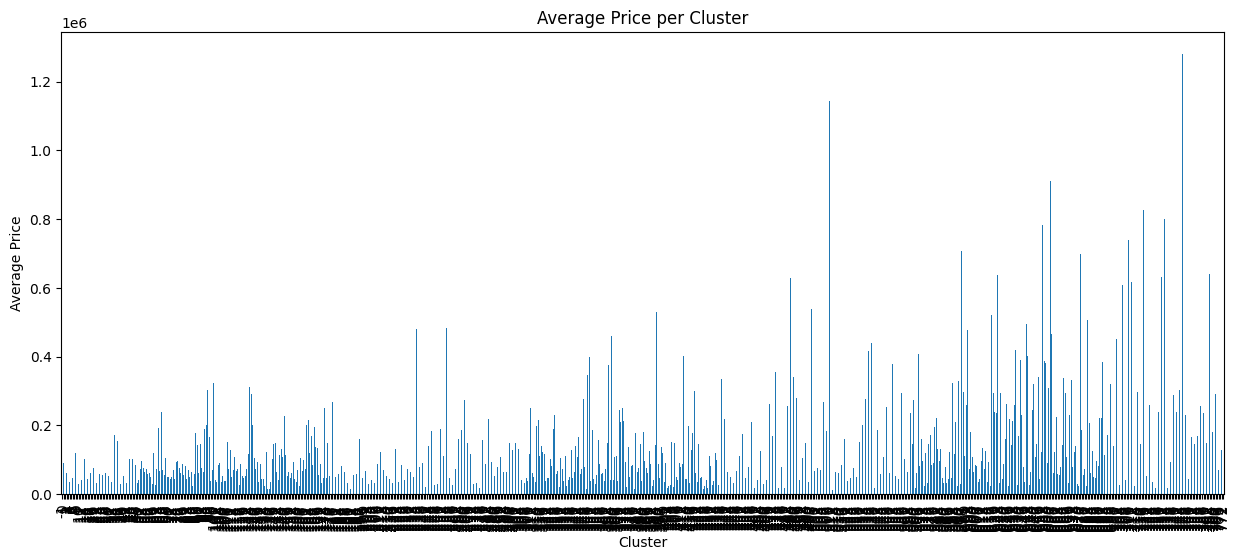

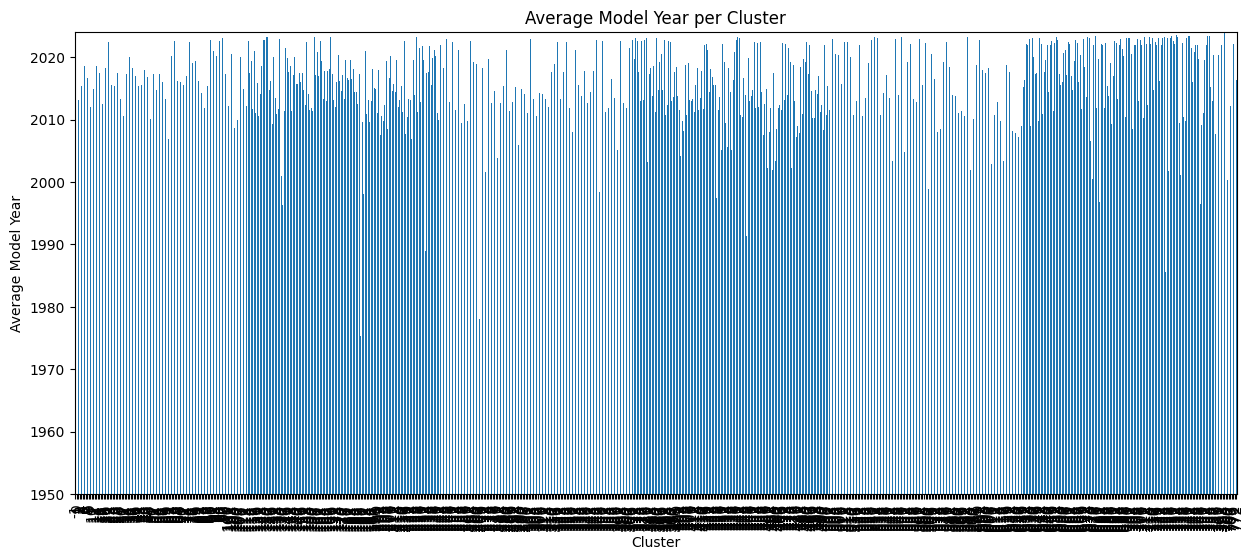

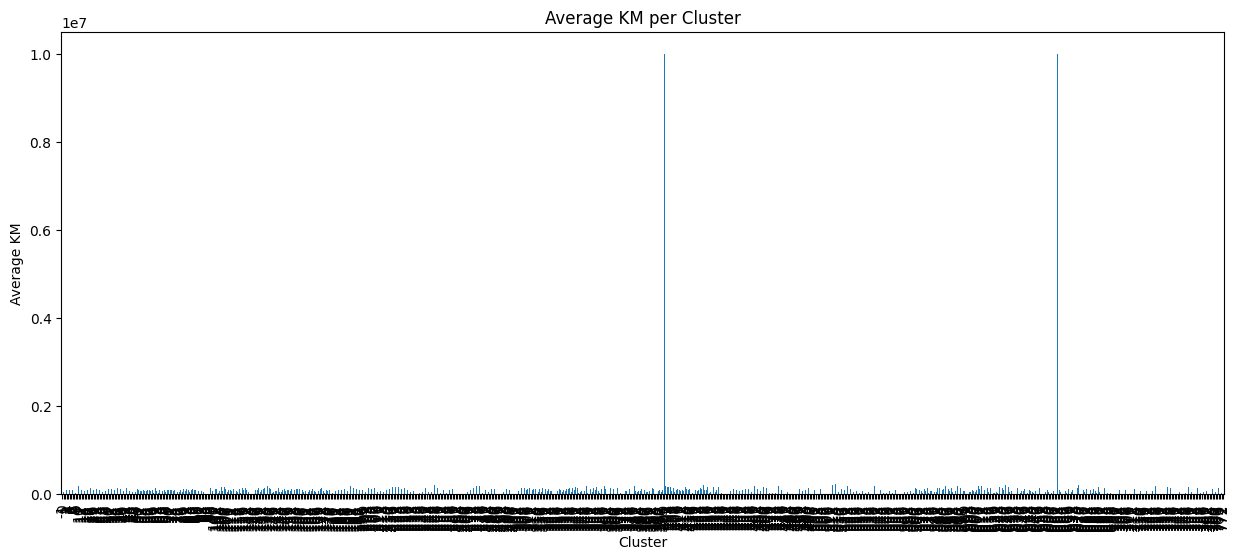

In [ ]:
# Show clusters and their traits (Macro)

# Load the data with cluster labels
clustered_data_path = '/content/drive/MyDrive/Datasets/clustered_data.csv'
df_clustered = pd.read_csv(clustered_data_path)

# Calculate mean (or median) for key features in each cluster
cluster_summary = df_clustered.groupby('cluster')[['price', 'model_year', 'km']].mean()  # replace with relevant features

# Plotting mean price for each cluster
plt.figure(figsize=(15, 6))
cluster_summary['price'].plot(kind='bar')
plt.title('Average Price per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Price')
plt.show()

# Plotting mean model year for each cluster
plt.figure(figsize=(15, 6))
cluster_summary['model_year'].plot(kind='bar')
plt.title('Average Model Year per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Model Year')
plt.ylim(1950, 2024)
plt.show()

# Plotting mean price for each cluster
plt.figure(figsize=(15, 6))
cluster_summary['km'].plot(kind='bar')
plt.title('Average KM per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average KM')
plt.show()

In [ ]:
# Functions to evaluate Inter-Cluster and Intra-Cluster Distances
# Randomly takes 30 samples of each cluster and measures distances
# WARNING: Takes about 2 hrs to run

def calculate_intra_cluster_distances(df, labels, sample_size=30):
    intra_cluster_distances = []

    for cluster_id in set(labels):
        if cluster_id != -1:  # Exclude noise points
            rows_in_cluster = df[labels == cluster_id]
            # Sample data if the cluster is large enough
            if len(rows_in_cluster) > sample_size:
                rows_in_cluster = resample(rows_in_cluster, n_samples=sample_size, random_state=42, replace=False)
            distances = gower.gower_matrix(rows_in_cluster)
            mean_distance = np.mean(distances)
            intra_cluster_distances.append(mean_distance)

    return np.mean(intra_cluster_distances)

def calculate_inter_cluster_distances(df, labels, sample_size=30):
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)  # Exclude noise points
    unique_labels = list(unique_labels)

    inter_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            rows_in_cluster_i = df[labels == unique_labels[i]]
            rows_in_cluster_j = df[labels == unique_labels[j]]
            # Sample data from both clusters
            if len(rows_in_cluster_i) > sample_size:
                rows_in_cluster_i = resample(rows_in_cluster_i, n_samples=sample_size, random_state=42, replace=False)
            if len(rows_in_cluster_j) > sample_size:
                rows_in_cluster_j = resample(rows_in_cluster_j, n_samples=sample_size, random_state=42, replace=False)
            distances = gower.gower_matrix(rows_in_cluster_i, rows_in_cluster_j)
            mean_distance = np.mean(distances)
            inter_cluster_distances.append(mean_distance)

    return np.mean(inter_cluster_distances)

In [ ]:
# Evaluate Inter-Cluster and Intra-Cluster Distances
# Randomly takes 30 samples of each cluster and measures distances
# WARNING: Takes about 2 hrs to run

model_filename = '/content/drive/MyDrive/Datasets/dbscan_model.pkl'

with open(model_filename, 'rb') as file:
    loaded_dbscan = pickle.load(file)

# Get the cluster labels from the loaded model
labels = loaded_dbscan.labels_

# Count the number of clusters and noise points (same as before)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

average_intra_cluster_distance = calculate_intra_cluster_distances(car_data_dense, labels)

print(f"Average Intra-Cluster Distance: {average_intra_cluster_distance}")

average_inter_cluster_distance = calculate_inter_cluster_distances(car_data_dense, labels)

print(f"Average Inter-Cluster Distance: {average_inter_cluster_distance}")

print(f"\nRatio of Distances: {average_inter_cluster_distance / average_intra_cluster_distance}")



Estimated number of clusters: 773
Estimated number of noise points: 6829
Average Intra-Cluster Distance: 0.0008236176217906177
Average Inter-Cluster Distance: 0.012004779651761055

Ratio of Distances: 14.575671195983887


# DBSCAN Conclusions

## Performance

- Computational Load: DBSCAN is resource-heavy, but with the right optimizations in a remote environment like Google Colab, it runs reasonably quickly (for me it took 20 minutes after utilizing all cores with the parameter `n_jobs`).
- Noise Points: DBSCAN identified 6,829 points of data that it could not satisfactorily categorize into one cluster. These are marked as "-1" cluster, and only consist of about 5% of our dataset, which is reasonably low considering our outliers.
- Inter- and Intra- Cluster Distances: These calculations measure how different the items are within the cluster (inter) and how different the clusters are from each other (intra). Ideally, we want the Inter Distance to be higher, and the Intra Distance to be lower. The ratio of Inter to Intra Distances should be high, ideally 1 or greater. The ratio found for our DBSCAN run is quite high, and suggests DBSCAN handles our data well.

## Conclusions

- Cluster Number: 773 clusters is enough clusters to reasonably group about 150 items for recommendation. I think it provides enough variety for more granular recommendation without being too specific.
- Adding new data to clusters: DBSCAN works by running through the whole dataset and clustering. This is not suitable for adding just a few new points of data. However, if the dataset doubles or increases substantially, rerunning DBSCAN outside of production and introducing the new clusters to production might be wise. However, we need a production-ready way to add new data to our existing clusters. There were these options:
  - ### HDBSCAN (Hierarchical DBSCAN)
HDBSCAN is an extension of DBSCAN, which transforms the space according to the density/sparsity of regions and then performs hierarchical clustering. It's particularly useful for datasets where cluster density varies significantly.
    - **Hierarchical Clustering**: It builds a hierarchy of clusters and uses a stability-based approach to select the most persistent clusters.
    - **Handling Different Density Clusters**: Unlike DBSCAN, HDBSCAN can handle varying densities.
    - **No Need to Specify `eps`**: It requires fewer hyperparameters (no `eps` parameter like in DBSCAN).

    - **Adding New Data:**
      - While HDBSCAN does not natively support incremental clustering, it's more flexible than DBSCAN for adding new data. The entire dataset doesn't necessarily need to be re-clustered, but re-running the algorithm may still be needed to accurately incorporate new points.

  - ### Incremental DBSCAN
  Incremental DBSCAN refers to modifications of the DBSCAN algorithm that can handle data streams or incremental data. These algorithms are designed to update clusters as new data arrives without re-running the entire clustering process.

    - **Key Features:**
      - **Efficiency with Streaming Data**: Ideal for situations where data is continuously updated.
      - **Adapting to New Data**: It updates existing clusters with new data points without needing to reprocess the entire dataset.

    - **Adding New Data:**
      - Specifically designed to add new points to existing clusters or form new clusters as required.

I decided to try out Incremental DBSCAN due to its ability to add new points to existing clusters without having to rerun the whole algorithm.

In [ ]:
# Add new data points

# Use a csv of 100 new mock data points
mock_data_path = '/content/drive/MyDrive/Datasets/mock_new_data.csv'
mock_data = pd.read_csv(mock_data_path)

# Load DBSCAN model and clusters
model_filename = '/content/drive/MyDrive/Datasets/dbscan_model.pkl'
with open(model_filename, 'rb') as file:
    loaded_dbscan = pickle.load(file)

current_clusters_path = '/content/drive/MyDrive/Datasets/clustered_data.csv'
clustered_data = pd.read_csv(current_clusters_path)
clusters = clustered_data['cluster']

# Preprocess data
mock_data_cleaned = preprocess_data(mock_data)
print(mock_data_cleaned.head())
_, _, mock_data_preprocessed, _ = scale_encode_data(mock_data_cleaned, fitted_preprocessor)

# Use custom Incremental DBSCAN to add new data to clusters
def incremental_dbscan(dbscan_model, original_data, new_data, eps):
    # Calculate distances from new data points to all points in the original dataset
    distances = pairwise_distances(new_data, original_data, metric='euclidean')

    # Use a sparse matrix to save memory for large datasets
    sparse_distances = csr_matrix(distances <= eps)

    # Check for each new data point
    for i, row in enumerate(sparse_distances):
        neighbor_indices = row.indices

        # If the new point has less than 'min_samples' neighbors, label it as noise (-1)
        if len(neighbor_indices) < dbscan_model.min_samples:
            yield -1
            continue

        # Find clusters of the neighbors
        neighbor_clusters = set(clusters[neighbor_indices])

        # If neighbors belong to more than one cluster or no clusters, label as noise (-1)
        if len(neighbor_clusters) != 1 or -1 in neighbor_clusters:
            yield -1
        else:
            # Assign to the cluster of the neighbors
            yield neighbor_clusters.pop()

new_clusters = list(incremental_dbscan(loaded_dbscan, car_data_preprocessed, mock_data_preprocessed, loaded_dbscan.eps))

   model_year       km    price  is_new  fuel_id  doors  transmission_id  \
0        1994  8494637  1470360       1        5      4                1   
1        1981   620146  8041995       1        5      3                4   
2        2010  6979779  5170217       0        6      3                2   
3        1954  1227060  7995091       0        9      3                1   
4        2019  2705249  2466554       0        2      4                1   

   body_style_id  model_id  
0              9       391  
1              3      1112  
2             13       425  
3             11       858  
4              1     10386  


In [ ]:
# Output new clusters

# Create a deep copy of the DataFrame
mock_copy = mock_data.copy(deep=True)

# Add the cluster labels to the new dataframe
mock_copy['cluster'] = new_clusters

# Concatenate the original and new data
combined_data = pd.concat([clustered_data, mock_copy], ignore_index=True)

# Save the combined data to a CSV file
combined_data.to_csv('combined_clustered_data.csv', index=False)

!cp combined_clustered_data.csv /content/drive/MyDrive/Datasets/

In [ ]:
# Prepare new clusters for evaluation

# Convert the sparse matrix to a dense numpy array
mock_data_dense = mock_data_preprocessed.toarray()

# Concatenate the original and new preprocessed data
combined_data_preprocessed = np.concatenate([car_data_dense, mock_data_dense])

def incremental_dbscan_batch(dbscan_model, original_data, new_data, eps, batch_size=100):
    n_new_data = new_data.shape[0]
    new_clusters = np.full(n_new_data, -1, dtype=int)  # Initialize all new data points as noise

    # Process new data in batches
    for batch_start in range(0, n_new_data, batch_size):
        batch_end = min(batch_start + batch_size, n_new_data)
        batch_new_data = new_data[batch_start:batch_end]

        # Calculate distances from new data points in the batch to all points in the original dataset
        distances = pairwise_distances(batch_new_data, original_data, metric='euclidean')

        # Use a sparse matrix to save memory
        sparse_distances = csr_matrix(distances <= eps)

        # Check for each new data point in the batch
        for i, row in enumerate(sparse_distances):
            neighbor_indices = row.indices

            # If the new point has less than 'min_samples' neighbors, continue as noise (-1)
            if len(neighbor_indices) < dbscan_model.min_samples:
                continue

            # Find clusters of the neighbors
            neighbor_clusters = set(clusters[neighbor_indices])

            # If neighbors belong to more than one cluster or no clusters, continue as noise (-1)
            if len(neighbor_clusters) != 1 or -1 in neighbor_clusters:
                continue
            else:
                # Assign to the cluster of the neighbors
                new_clusters[batch_start + i] = neighbor_clusters.pop()

    return new_clusters

# Adjust the batch size based on available memory and dataset size
batch_size = 100  # You may need to fine-tune this number
combined_clusters = incremental_dbscan_batch(loaded_dbscan, car_data_preprocessed, combined_data_preprocessed, loaded_dbscan.eps, batch_size)

# Convert to dataframe
combined_clusters_df = pd.DataFrame(combined_clusters, columns=['cluster'])

# Save to CSV
output_filename = 'combined_cluster_assignments.csv'
combined_clusters_df.to_csv(output_filename, index=False)

!cp combined_cluster_assignments.csv /content/drive/MyDrive/Datasets/

In [ ]:
# Evaluate new clusters
# Randomly takes 30 samples of each cluster and measures distances
# WARNING: Takes about 2 hrs to run

# Use a csv of 100 new mock data points
cluster_assignments_path = '/content/drive/MyDrive/Datasets/combined_cluster_assignments.csv'
retrieved_clusters = pd.read_csv(cluster_assignments_path)
retrieved_clusters = retrieved_clusters['cluster']

average_intra_cluster_distance = calculate_intra_cluster_distances(combined_data_preprocessed, retrieved_clusters)

print(f"Average Intra-Cluster Distance: {average_intra_cluster_distance}")

average_inter_cluster_distance = calculate_inter_cluster_distances(combined_data_preprocessed, retrieved_clusters)

print(f"Average Inter-Cluster Distance: {average_inter_cluster_distance}")

print(f"\nRatio of Distances: {average_inter_cluster_distance / average_intra_cluster_distance}")

Average Intra-Cluster Distance: 0.0008227538201026618
Average Inter-Cluster Distance: 0.012108692899346352

Ratio of Distances: 14.717273712158203


# Incremental DBSCAN Conclusions

## Performance

- Quick: Incremental DBSCAN runs very quickly, about 10 minutes.
- Accuracy Evaluation: I created mock data to test Incremental DBSCAN on. However, the mock data I created did not utilize patterns inherent in the source data, such as outlier patterns and data with higher numbers. Instead, I chose random points in the source data to create new rows. This means that the mock data would be harder to cluster. However, evaluating the new combined dataset with Inter- and Intra Cluster Distance metrics showed that the algorithm still performed very well.

In order to perform Incremental DBSCAN, you must keep a copy of the original DBSCAN model.

If you want to evaluate clusters after many runs of Incremental DBSCAN, you must also keep a copy of the original data before adding new data points to accurately measure.

## Conclusion

I think that DBSCAN performs well enough for clustering and has a lightweight enough method for adding new data points to be usable in production. I think it's a great solution for cold-starting item recommendation, and will do the job for now if/until we want to pivot to more robust recommendation systems with user data.